In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.io import savemat, loadmat
import matlab.engine # to run Cheng's code
import time
# import os

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

# import compare_with_benchmark as bn
import my_simgraph_06 as sg
import data_handler_01 as dh

In [3]:
# save the dataset on disc
data_path = '../../data/fe_exp/cheng_snap_3/'
train_data = loadmat(data_path+'data_30_50_2.mat')

In [5]:
train_dess_nrm = dh.normalize(train_data['train_des'], feature_nrm=1, node_nrm=30)

In [7]:
savemat(data_path+'data_30_50_2_nrm.mat', {'train_des': train_dess_nrm, 'train_lbls': train_data['train_lbls']})

In [6]:
train_dess_nrm

array([[-4.625723 , -4.2036443, -4.056236 , ..., -4.3641396,  4.157727 ,
        -4.2284317],
       [-4.49392  , -4.340096 , -4.1400824, ..., -4.360802 ,  4.695469 ,
        -4.162595 ],
       [-4.526868 , -4.1355257, -4.071872 , ..., -4.192881 ,  3.920183 ,
        -4.04496  ],
       ...,
       [-4.538557 , -4.450864 , -4.1717772, ..., -3.9763079,  4.3384223,
        -4.2508726],
       [-4.5498867, -4.4614015, -4.3375173, ..., -4.2852874,  4.4829197,
        -3.9949212],
       [-4.290219 , -3.6307404, -4.158621 , ..., -4.3661885,  4.1921763,
        -4.1737547]], dtype=float32)

In [ ]:
savemat(data_path+'data.mat', {'train_des': train_des, 'train_lbls': train_lbls})

In [4]:
train_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Apr 26 17:01:03 2023',
 '__version__': '1.0',
 '__globals__': [],
 'train_des': array([[2.6957638, 1.8614454, 2.0306978, ..., 2.6020913, 5.0531607,
         1.7509017],
        [2.74855  , 1.8661888, 2.052212 , ..., 2.6338816, 5.167392 ,
         1.842858 ],
        [2.7275314, 1.8944288, 2.0302465, ..., 2.6534164, 5.0039086,
         1.8360116],
        ...,
        [2.7377229, 1.8060669, 2.0278964, ..., 2.717731 , 5.080417 ,
         1.7895442],
        [2.7620263, 1.8447154, 2.0045779, ..., 2.675387 , 5.113314 ,
         1.941215 ],
        [2.7480686, 2.0853992, 1.9743812, ..., 2.5864785, 5.0539947,
         1.7585819]], dtype=float32),
 'train_lbls': array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -

# Load spike data

Spike data shape:  (297, 1141, 113) $\implies$ (movie repeats, frames/time, neurons)
<br>
Labels are 1 (= spike) or -1 (= no spike).

In [2]:
# load all spike data from file
spikes_dp = '../../data/original_files/spikes.csv'
binned_data = np.loadtxt(spikes_dp, delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

## Group all 113 neurons

This will create a more balanced dataset which is presumabley easier to solve.
<br>
Grouped data shape:  (297, 1141, 1) $\implies$ (movie repeats, frames/time, group)

In [3]:
# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1

In [4]:
# print some statistics
print('grouped_data.shape = ', grouped_data.shape)

avg_spike_perc = 0
print('trial #    | percentage belonging to class 1')
print('---------------------------------------------')
for trial in range(10):
    pers = dh.class_percentages(grouped_data[trial, :, :].reshape(-1), [-1, 1])
    avg_spike_perc += pers[1]
    print('trial #{:3} | {:.2f} %'.format(trial, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f} %'.format(avg_spike_perc))

total_perc = np.sum(grouped_data == 1) *100 /(grouped_data.shape[0] * grouped_data.shape[1])
print('---------------------------------------------')
print('{:.2f} % of the whole data belongs to class 1.'.format(total_perc))

grouped_data.shape =  (297, 1141, 1)
trial #    | percentage belonging to class 1
---------------------------------------------
trial #  0 | 66.26 %
trial #  1 | 69.06 %
trial #  2 | 67.92 %
trial #  3 | 71.08 %
trial #  4 | 68.97 %
trial #  5 | 68.27 %
trial #  6 | 66.87 %
trial #  7 | 65.82 %
trial #  8 | 67.66 %
trial #  9 | 68.19 %
---------------------------------------------
AVERAGE     | 68.01 %
---------------------------------------------
68.47 % of the whole data belongs to class 1.


## Create training and validation datasets

In [5]:
# only consider the second trial
ind_min = 1*1141+0
ind_max = 2*1141-1
# train_num = int(data_num*0.8)
# val_num = data_num - train_num
train_num = 210
val_num = 100

def transform(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[:, 1000::2500]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

data_params = {'func': dh.datapoint_torch, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/slowfast/slowfast_4732/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform}

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, ind_min, ind_max, data_params, seed=1342)

# show statistics
print('train_num = ', train_num, ', val_num = ', val_num)
print('# of features = ', train_data['des'].shape[1])
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))

# print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
# print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
# print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

train_num =  210 , val_num =  100
# of features =  2
training data contains 105 points (50.00%) of label 1.
validation data contains 50 points (50.00%) of label 1.


In [6]:
train_des = train_data['des']
train_lbls = train_data['lbls']
val_des = val_data['des']
val_lbls = val_data['lbls']

Text(0.5, 1.0, 'Validation Dataset')

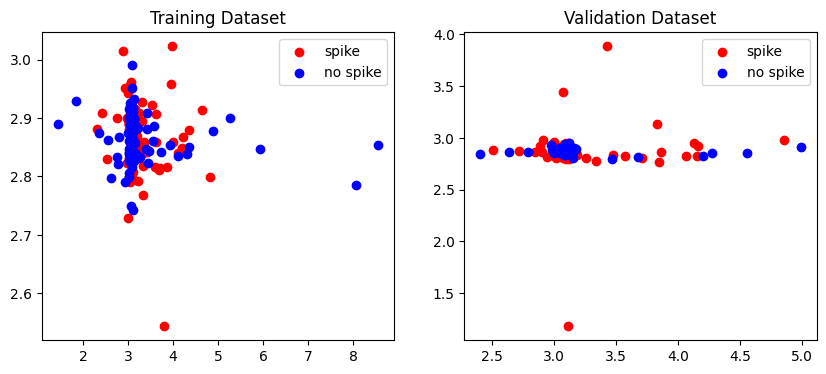

In [7]:
# visualize the datasets
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(train_des[:train_num//2,0], train_des[:train_num//2,1], color='r')
plt.scatter(train_des[train_num//2:,0], train_des[train_num//2:,1], color='b')
plt.legend(['spike', 'no spike'])
plt.title('Training Dataset')

plt.subplot(1,2,2)
plt.scatter(val_des[:val_num//2,0], val_des[:val_num//2,1], color='r')
plt.scatter(val_des[val_num//2:,0], val_des[val_num//2:,1], color='b')
plt.legend(['spike', 'no spike'])
plt.title('Validation Dataset')

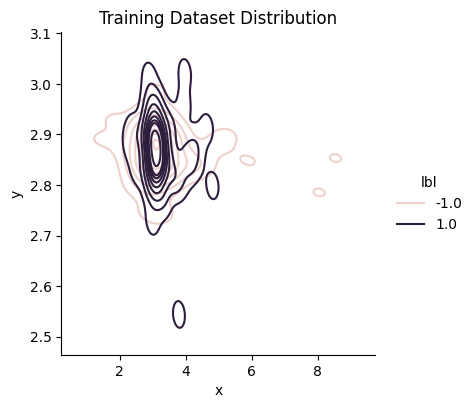

In [8]:
train_dataframe = pd.DataFrame(np.append(train_des, train_lbls.reshape((-1, 1)), axis=1), columns=['x', 'y', 'lbl'])
val_dataframe = pd.DataFrame(np.append(val_des, val_lbls.reshape((-1, 1)), axis=1), columns=['x', 'y', 'lbl'])


g = sns.displot(train_dataframe, x='x', y='y', hue='lbl', kind='kde', height=4)
g.set(title='Training Dataset Distribution')

# g = sns.displot(val_dataframe, x='x', y='y', hue='lbl', kind='kde', height=4)
# g.set(title='Validation Dataset Distribution')

In [9]:
# save the dataset on disc
data_path = '../../data/fe_exp/cheng_snap/'
savemat(data_path+'data.mat', {'train_des': train_des, 'train_lbls': train_lbls})

# Train the logistic regression model

In [142]:
# instantiate the model
lgrg = LogisticRegression(penalty='none')

In [143]:
print('Parameters used for fitting: \n', lgrg.get_params())

Parameters used for fitting: 
 {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'none', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [144]:
# train the model  
lgrg = lgrg.fit(train_des, train_lbls)

## Analyze the optimized parameters

In [145]:
# print optimized parameters
print('classes = ', lgrg.classes_)
print('decision boundary coefficients = ', lgrg.coef_)
print('decision boundary bias = ', lgrg.intercept_)
print('number of features seen during fit = ', lgrg.n_features_in_)
print('number of iterations done during fit = ', lgrg.n_iter_)

classes =  [-1.  1.]
decision boundary coefficients =  [[-0.09709145  1.28040172]]
decision boundary bias =  [-3.35481415]
number of features seen during fit =  2
number of iterations done during fit =  [19]


In [146]:
# compute confidence scores - positive means +1 while negative means -1
print('a(x) for all x\'s = \n', lgrg.decision_function(val_des))

a(x) for all x's = 
 [-0.01652562 -0.03433868  0.03900113  0.03246614  0.09385364 -0.0076142
 -0.05375139  0.75084035 -0.17909572  0.14601649  0.0702545   1.28702876
  0.10294693  0.03294103  0.06616619 -0.07759213 -0.02489839 -0.05806437
 -0.06176073  0.05105189 -0.06480625 -0.07401904  0.11535006  0.07456223
 -0.03031182 -0.13429336  0.02309024  0.11765611 -0.12064699  0.05689132
  0.17798514 -0.01821359 -0.0627401  -0.08166242  0.28924368 -0.0760821
 -0.13732924  0.07774502  0.11432285 -0.06607894 -2.14475829 -0.01224035
 -0.11699498 -0.06246278 -0.02082636  0.03136736 -0.00885405  0.01169543
 -0.00802959 -0.046654   -0.10575597 -0.01511718  0.03500517  0.05129608
  0.04201409  0.00255655  0.01132803  0.03283494  0.01321779 -0.07029452
 -0.00418746  0.06220482 -0.01654385  0.0173246   0.09605175  0.0779753
  0.05780606  0.05546622 -0.10574314  0.05800592  0.02952829  0.11732674
  0.00942723  0.04395052  0.03167628  0.0085668   0.04193888  0.04995417
 -0.10392284 -0.10874004  0.06517

In [147]:
lgrg.predict_log_proba(val_des)

array([[-0.68491851, -0.70144413],
       [-0.67612523, -0.71046391],
       [-0.71283787, -0.67383674],
       [-0.709512  , -0.67704586],
       [-0.74117466, -0.64732102],
       [-0.68934733, -0.69696153],
       [-0.66663259, -0.72038398],
       [-1.13744183, -0.38660148],
       [-0.60760338, -0.78669911],
       [-0.76881816, -0.62280167],
       [-0.72889126, -0.65863677],
       [-1.5308294 , -0.24380063],
       [-0.74594482, -0.64299789],
       [-0.70975333, -0.6768123 ],
       [-0.72677742, -0.66061123],
       [-0.6551035 , -0.73269562],
       [-0.68077548, -0.70567386],
       [-0.66453637, -0.72260074],
       [-0.66274354, -0.72450427],
       [-0.71899888, -0.66794699],
       [-0.66126894, -0.7260752 ],
       [-0.65682236, -0.7308414 ],
       [-0.75248449, -0.63713443],
       [-0.73112307, -0.65656085],
       [-0.67810612, -0.70841794],
       [-0.62825315, -0.76254651],
       [-0.70475895, -0.6816687 ],
       [-0.75370461, -0.6360485 ],
       [-0.63464204,

[Text(0.5, 1.0, 'Logistic Regression Decision Boundary on Train Data')]

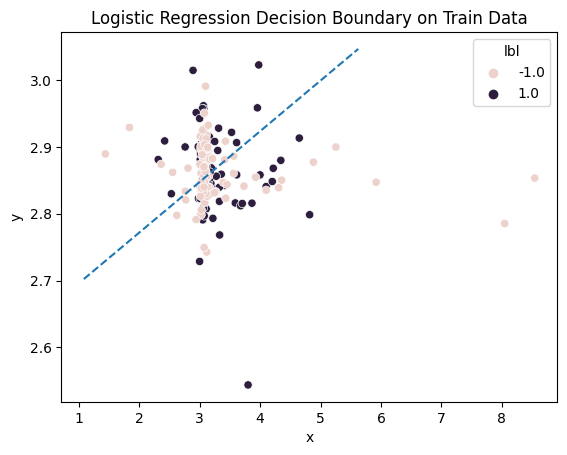

In [148]:
# draw a scatterplot of train data
g = sns.scatterplot(x=train_dataframe.x, y=train_dataframe.y, hue=train_dataframe.lbl)

# draw the optimized decision boundary
slope = -lgrg.coef_[0,0] / lgrg.coef_[0,1]
intercept = -lgrg.intercept_[0] / lgrg.coef_[0,1]
decision_x = np.array(g.get_xlim())
decision_y = intercept + slope * decision_x
[y_limlo, y_limup] = np.array(g.get_ylim())
if decision_y[0] > y_limup:
    decision_y[0] = y_limup
    decision_x[1] = 1/slope * decision_y[0] - intercept / slope
if decision_y[0] < y_limlo:
    decision_y[0] = y_limlo
    decision_x[1] = 1/slope * decision_y[0] - intercept / slope
if decision_y[1] > y_limup:
    decision_y[1] = y_limup
    decision_x[1] = 1/slope * decision_y[1] - intercept / slope
if decision_y[1] < y_limlo:
    decision_y[1] = y_limlo
    decision_x[1] = 1/slope * decision_y[1] - intercept / slope
g.plot(decision_x, decision_y, '--')
g.set(title='Logistic Regression Decision Boundary on Train Data')

## Validate the logistic regression model

In [149]:
# validate the model
val_loc = np.arange(val_num)
val_spikes = val_loc[val_lbls > 0]
preds_lgrg = lgrg.predict(val_des)
val_acc_lgrg = lgrg.score(val_des, val_lbls)

est_spikes_lgrg = val_loc[preds_lgrg > 0]
if sum(val_lbls==1) == 0:
    missed_lgrg = 0
else:
    missed_lgrg = sum(np.logical_and(val_lbls==1, preds_lgrg < 0))/sum(val_lbls==1)
if sum(val_lbls==-1) == 0:
    false_alarm_lgrg = 0
else:
    false_alarm_lgrg = sum(np.logical_and(val_lbls==-1, preds_lgrg > 0))/sum(val_lbls==-1)

print('Predicted labels WITH threshold =\n', preds_lgrg)
print('Validation accuracy =\n', val_acc_lgrg)
print('Estimated spike time bins: ', est_spikes_lgrg)
print('Real spike time bins: ', val_spikes)
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_lgrg*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_lgrg*100))

Predicted labels WITH threshold =
 [-1. -1.  1.  1.  1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1. -1. -1. -1.
 -1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1.  1.  1. -1. -1. -1.  1. -1.
 -1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1. -1. -1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1. -1.  1.
  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.]
Validation accuracy =
 0.37
Estimated spike time bins:  [ 2  3  4  7  9 10 11 12 13 14 19 22 23 26 27 29 30 34 37 38 45 47 52 53
 54 55 56 57 58 61 63 64 65 66 67 69 70 71 72 73 74 75 76 77 80 81 82 85
 89 90 91 92 93 94 96 97 98]
Real spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Missed spikes (/all spikes): 56.00%
False spikes (/all no-spike bins): 70.00%


# Train the similarity graph model with GDPA

In [150]:
# import importlib
# importlib.reload(sg)

## Run Cheng's code

In [151]:
eng = matlab.engine.start_matlab()
eng.cd(r'/home/yasamanparhizkar/Documents/yorku/01_thesis/code/15_cheng', nargout=0)
M_gdpa = eng.gdpa_fit('test')
M_gdpa = np.array(M_gdpa)
eng.quit()

starting SGML.
initial objective value = -51.7153
converged objective value = -104.389
minimal eigenvalue of M = 1e-05
done with SGML.


In [152]:
print('Optimized M computed by Chengs code:\n', M_gdpa)

Optimized M computed by Chengs code:
 [[1.99998924e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e-05]]


## Analyze the optimized parameters

M_gdpa = 
 [[1.99998924e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e-05]]


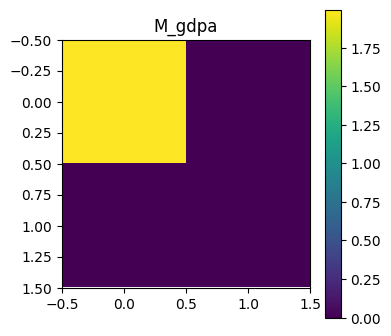

In [153]:
# display the optimized B
print('M_gdpa = \n', M_gdpa)
sg.display_matrix(M_gdpa, 'M_gdpa')

## Validate the similarity graph

In [154]:
# graph construction and penalty term parameters
sg_params = {'mu': 30, 'Dt': None, 'Dv': 0, 'Dvt': 2000, \
             'cnstr_method_tt': 'time', 'cnstr_method_vv': 'time', 'cnstr_method_vt': 'time',\
             'train_t': np.arange(len(train_lbls)), 'val_t': np.arange(len(val_lbls)), \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

val_acc_gdpa, y_est_gdpa, t_gdpa = sg.get_acc(M_gdpa, train_des, train_lbls, val_des, val_lbls, sg_params, seed=0, show_edges=False)
print('Elapsed time = {} ms'.format(t_gdpa*1000))

Elapsed time = 125.66232681274414 ms


In [155]:
# print results
print('val acc = {:.2f}%'.format(val_acc_gdpa*100))
print('estimated val labels WITH threshold = ', 2*(y_est_gdpa>0).astype(np.int32)-1)
print('Estimated validation labels withOUT threshold:\n', y_est_gdpa)

val acc = 56.00%
estimated val labels WITH threshold =  [ 1  1 -1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1  1  1
 -1  1  1 -1  1 -1 -1  1 -1  1  1 -1  1 -1 -1  1 -1 -1  1 -1  1 -1  1 -1
 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1  1 -1  1  1  1 -1 -1 -1  1 -1
 -1 -1  1 -1]
Estimated validation labels withOUT threshold:
 [ 1.34445850e-01  3.83740399e-03 -3.25483442e-03  1.12377967e-03
 -2.16901461e-02  3.63729883e-03 -4.67741294e-03 -2.21629737e-03
  9.04482128e-02 -5.69952519e-03 -7.84250876e-04  2.36431139e-02
 -9.87901054e-03 -9.29239891e-03 -1.52970146e-02  4.04921326e-02
 -1.21799591e-04  2.87201606e-02 -1.11220403e-03 -5.72078012e-03
 -1.36078920e-04  8.61266645e-03  2.45437278e-04  3.70940276e-04
 -7.91281967e-03  1.69051579e-01  1.62691540e-01 -1.03814236e-03
  6.24492610e-02 -1.29228825e-03 -9.00653001e-03  2.26160579e-03
 -7.78842438e-04  1.58971389e-04  8.65134169e-02 -9.83130731e-04
  1.4

In [156]:
# comparing estimated and real spike locations
val_loc = np.arange(val_num)
val_spikes = val_loc[val_lbls==1]
est_spikes_gdpa = val_loc[y_est_gdpa > 0]

if sum(val_lbls==1) == 0:
    missed_gdpa = 0
else:
    missed_gdpa = sum(np.logical_and(val_lbls==1, y_est_gdpa < 0))/sum(val_lbls==1)

if sum(val_lbls==-1) == 0:
    false_alarm_gdpa = 0
else:
    false_alarm_gdpa = sum(np.logical_and(val_lbls==-1, y_est_gdpa > 0))/sum(val_lbls==-1)

nospk_per = np.sum(val_lbls==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes_gdpa)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_gdpa*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_gdpa*100))

Estimated spike time bins:  [ 0  1  3  5  8 11 15 17 21 22 23 25 26 28 31 33 34 36 39 42 44 46 49 50
 56 59 60 62 66 68 78 79 83 84 86 88 89 90 94 98]
Real spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 54.00%
False spikes (/all no-spike bins): 34.00%


# Train the similarity graph model with factorization

In [157]:
# graph construction and penalty term parameters
sg_params = {'mu': 30, 'Dt': None, 'Dv': 0, 'Dvt': 2000, \
             'cnstr_method_tt': 'time', 'cnstr_method_vv': 'time', 'cnstr_method_vt': 'time',\
             'train_t': np.arange(len(train_lbls)), 'val_t': np.arange(len(val_lbls)), \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                  'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
                  'force_all_its': True, 'threshold': 0.01}

time0 = time.time()
B_fact, sg_stats_fact = sg.fit_graph(dess=train_des, lbls=train_lbls, graph_params=sg_params, opt_params=sg_opt_params, seed=0)
print('Elapsed time = {} sec'.format(time.time()-time0))

Number of training datapoints: 210
Number of features for each point: 2
mu = 30
   0: eps = 3.12e-02;  train loss (E) = 31497.92
   1: eps = 3.12e-02;  train loss (E) = 20243.02
   2: eps = 1.56e-02;  train loss (E) = 19677.60
   3: eps = 7.81e-03;  train loss (E) = 18719.82
   4: eps = 1.56e-02;  train loss (E) = 18718.75
   5: eps = 1.56e-02;  train loss (E) = 18718.16
   6: eps = 1.56e-02;  train loss (E) = 18717.24
   7: eps = 1.56e-02;  train loss (E) = 18716.30
   8: eps = 1.56e-02;  train loss (E) = 18714.33
   9: eps = 1.56e-02;  train loss (E) = 18710.54
Elapsed time = 3.3444395065307617 sec


## Display learned metric matrix

M_fact - Coordinates of elements with higher values than 49.33
[(0, 0)]


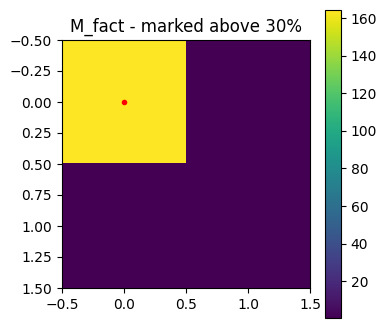

In [158]:
# display learned M
M_fact = B_fact.T @ B_fact

sg.display_matrix(M_fact, None)

# mark elements with high values
thresh = 30
lim = (thresh/100) * np.max(M_fact) # marker threshold
f_sz = M_fact.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M_fact > lim],yloc[M_fact > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M_fact - marked above {}%'.format(thresh))
print('M_fact - Coordinates of elements with higher values than {:.2f}'.format(lim))
print(list(zip(xloc[M_fact > lim],yloc[M_fact > lim])))

## Validate the similarity graph

In [159]:
val_acc_fact, y_est_fact, t_fact = sg.get_acc(M_fact, train_des, train_lbls, val_des, val_lbls, sg_params, seed=0, show_edges=False)

In [160]:
print('val acc = {:.2f}%'.format(val_acc_fact*100))
print('elapsed time = {:.2f} ms'.format(t_fact*1000))
print('estimated val labels = ', 2*(y_est_fact>0).astype(np.int32)-1)

val acc = 61.00%
elapsed time = 113.26 ms
estimated val labels =  [-1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1  1 -1 -1
  1  1  1 -1  1 -1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1  1  1 -1  1 -1 -1  1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1
 -1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1
 -1 -1 -1 -1]


In [161]:
# comparing estimated and real spike locations
est_spikes_fact = val_loc[y_est_fact > 0]

if sum(val_lbls==1) == 0:
    missed_fact = 0
else:
    missed_fact = sum(np.logical_and(val_lbls==1, y_est_fact < 0))/sum(val_lbls==1)

if sum(val_lbls==-1) == 0:
    false_alarm_fact = 0
else:
    false_alarm_fact = sum(np.logical_and(val_lbls==-1, y_est_fact > 0))/sum(val_lbls==-1)

nospk_per = np.sum(val_lbls==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes_fact)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_fact*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_fact*100))

Estimated spike time bins:  [ 4  8  9 12 13 15 19 21 24 25 26 28 30 34 36 39 41 42 44 47 68 69 70 73
 79 81 84 88 91]
Real spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 60.00%
False spikes (/all no-spike bins): 18.00%


## Comparison of all three methods

In [162]:
print('GDPA val acc = {:.2f}%'.format(val_acc_gdpa*100))
print('Factorization val acc = {:.2f}%'.format(val_acc_fact*100))
print('LogReg val acc = {:.2f}%'.format(val_acc_lgrg*100))

GDPA val acc = 56.00%
Factorization val acc = 61.00%
LogReg val acc = 37.00%


In [163]:
print('Real spike time bins: ', val_spikes)
print('GDPA Estimated spike time bins: ', est_spikes_gdpa)
print('Factorization Estimated spike time bins: ', est_spikes_fact)
print('LogReg Estimated spike time bins: ', est_spikes_lgrg)

Real spike time bins:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
GDPA Estimated spike time bins:  [ 0  1  3  5  8 11 15 17 21 22 23 25 26 28 31 33 34 36 39 42 44 46 49 50
 56 59 60 62 66 68 78 79 83 84 86 88 89 90 94 98]
Factorization Estimated spike time bins:  [ 4  8  9 12 13 15 19 21 24 25 26 28 30 34 36 39 41 42 44 47 68 69 70 73
 79 81 84 88 91]
LogReg Estimated spike time bins:  [ 2  3  4  7  9 10 11 12 13 14 19 22 23 26 27 29 30 34 37 38 45 47 52 53
 54 55 56 57 58 61 63 64 65 66 67 69 70 71 72 73 74 75 76 77 80 81 82 85
 89 90 91 92 93 94 96 97 98]


# Substitute factorization M into GDPA objective

In [164]:
gamma = 1.0
eng = matlab.engine.start_matlab()
eng.cd(r'/home/yasamanparhizkar/Documents/yorku/01_thesis/code/15_cheng/SGML-master/SGML_in_Matlab/', nargout=0)
V = eng.get_objective_variables_ready(train_des, train_lbls.reshape((train_num,1)), train_des.shape[0], train_des.shape[1], gamma)
eng.quit()
V = np.array(V)

In [165]:
loss_gdpa = np.sum(M_gdpa * V.T)
loss_fact = np.sum(M_fact * V.T)

print('GDPA loss with GDPA metric: ', loss_gdpa)
print('GDPA loss with Factorization metric: ', loss_gdpa)

GDPA loss with GDPA metric:  -104.3851984374095
GDPA loss with Factorization metric:  -104.3851984374095
